# Time series forecasting E-commerce sales using Deep Neural Net models

Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import dates

Available GPU for Tensorflow

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
matplotlib.style.use('seaborn-v0_8-white')

In [4]:
df_commerce = pd.read_csv('../data/e_commerce_uk.csv', encoding = 'ISO-8859-1')

In [5]:
df_commerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df_commerce.shape

(541909, 8)

In [7]:
df_commerce.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df_commerce.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df_commerce[df_commerce.Description.isna()].UnitPrice.sum()

0.0

In [10]:
df_w_unit_price = df_commerce[df_commerce.UnitPrice != 0].copy()

In [11]:
print(f'Removed: {len(df_commerce) - len(df_w_unit_price)}')

Removed: 2515


In [12]:
df_w_unit_price['Total'] = df_w_unit_price.Quantity * df_w_unit_price.UnitPrice

Plot occurrence of outliers

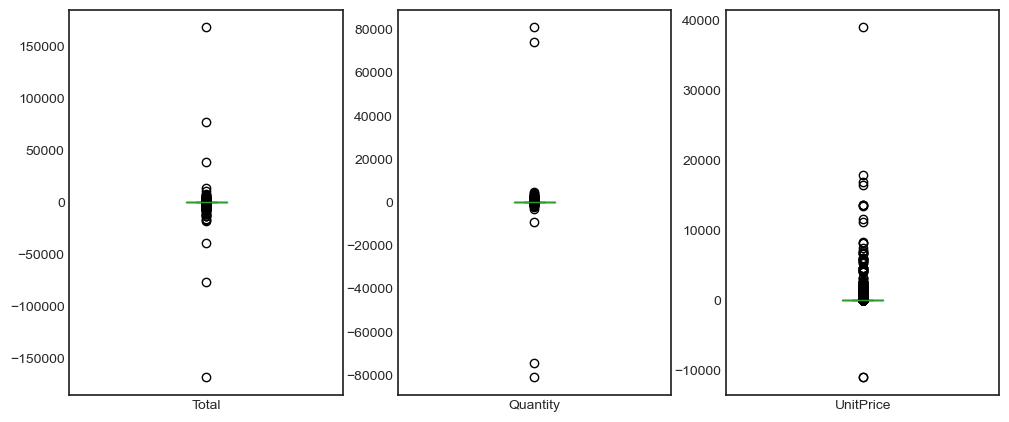

In [13]:
df_w_unit_price[['Total', 'Quantity', 'UnitPrice']].plot.box(subplots=True, figsize=(12, 5));

Let's detect statistically the outliers by using zscore along with transforming the numerical values into positive values.

In [14]:
z_scores = np.abs(stats.zscore(df_w_unit_price.Total))
z_scores.head()

0    0.007300
1    0.005974
2    0.010346
3    0.005974
4    0.005974
Name: Total, dtype: float64

Now, only the values that are lower than 3 std are selected as no outlier

In [15]:
no_outliers = z_scores < 3
df_no_outliers = df_w_unit_price[no_outliers]

In [16]:
df_no_outliers.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [17]:
print(f'Removed: {len(df_w_unit_price) - len(df_no_outliers)}')

Removed: 401


In [18]:
df_no_outliers['Jdate'] = pd.to_datetime(df_no_outliers.InvoiceDate).dt.date

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_57108/3108741979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Jdate'] = pd.to_datetime(df_no_outliers.InvoiceDate).dt.date


In [19]:
cols = ['Jdate', 'Total']
df_general_sales = df_no_outliers[cols].groupby('Jdate').sum()

In [20]:
df_general_sales.head()

,Total
Jdate,
2010-12-01,57008.36
2010-12-02,43146.48
2010-12-03,44306.46
2010-12-05,31383.95
2010-12-06,50906.98


In [21]:
df_general_sales = df_general_sales.reset_index()
df_general_sales.head()

,Jdate,Total
0,2010-12-01,57008.36
1,2010-12-02,43146.48
2,2010-12-03,44306.46
3,2010-12-05,31383.95
4,2010-12-06,50906.98


In [22]:
df_r_win = df_general_sales.copy()
df_r_win.Total = df_r_win.Total.rolling(window=30).mean()

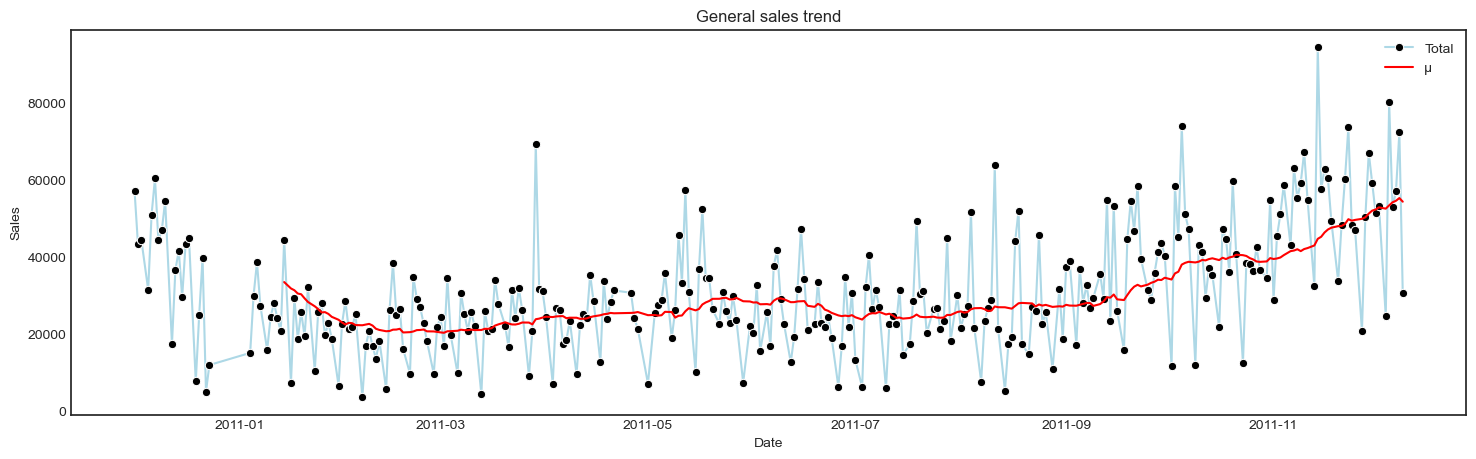

In [23]:
fig, ax = plt.subplots(figsize = (18,5))

sns.lineplot(ax=ax, data=df_general_sales.set_index('Jdate').iloc[:, 0], color="lightblue", marker='o', mfc='k', mec='white', label='Total')
g1 = sns.lineplot(ax=ax, data=df_r_win.set_index('Jdate').iloc[:, 0], color="red", label='µ')

g1.set_title('General sales trend')
g1.set_ylabel('Sales')
g1.set_xlabel('Date')

ax.legend();

In [24]:
x = df_general_sales.copy()
x['D'] = x.Jdate.astype(str).apply(lambda x: dates.datestr2num(x))

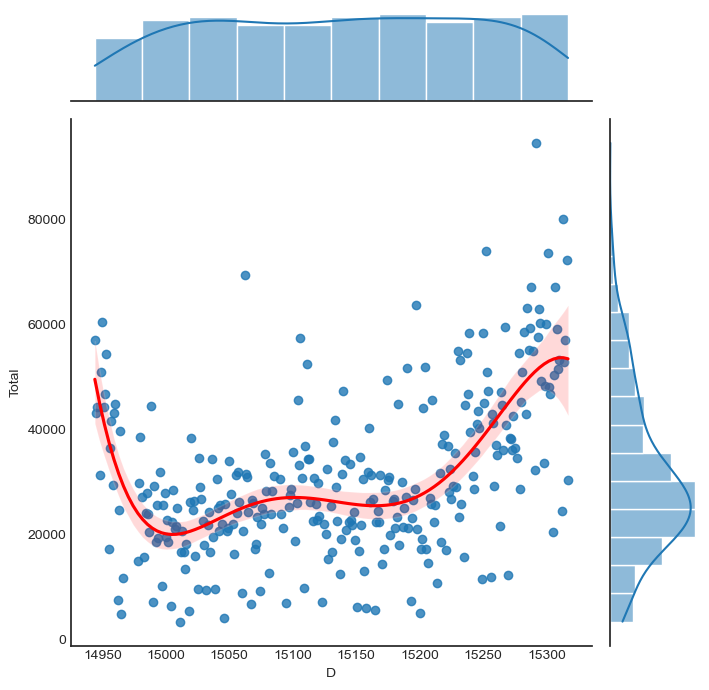

In [25]:
sns.jointplot(x="D", y="Total", data=x, kind="reg", order=5, height=7, line_kws={"color": "red"});

In [26]:
df_no_outliers = df_no_outliers.reset_index()

In [27]:
df_no_outliers = df_no_outliers.rename(columns={'index':'Id'})

The data is sliced to remain the important features for training

In [28]:
df_before_training = df_no_outliers[['Id', 'InvoiceDate', 'Total']].copy()

Transforming time

In [29]:
df_before_training['Jdate'] = pd.to_datetime(df_before_training.InvoiceDate)

In [30]:
df_before_training['Jseconds'] = df_before_training.Jdate.map(pd.Timestamp.timestamp)

As the interest lies on daily periodicity, the Jseconds needs to be transformed in sine and cosine to obtain 'Time of day'. This transformation allows for useful model input and gives the model access to the most important frequency features.

In [31]:
day = 24*60*60
year = (365.2425)*day

df_before_training['Day sin'] = np.sin(df_before_training.Jseconds * (2 * np.pi / day))
df_before_training['Day cos'] = np.cos(df_before_training.Jseconds * (2 * np.pi / day))
df_before_training['Year sin'] = np.sin(df_before_training.Jseconds * (2 * np.pi / year))
df_before_training['Year cos'] = np.cos(df_before_training.Jseconds * (2 * np.pi / year))

In [32]:
df_before_training.head()

,Id,InvoiceDate,Total,Jdate,Jseconds,Day sin,Day cos,Year sin,Year cos
0,0,12/1/2010 8:26,15.30,2010-12-01 08:26:00,1.291192e+09,0.803857,-0.594823,-0.502296,0.864696
1,1,12/1/2010 8:26,20.34,2010-12-01 08:26:00,1.291192e+09,0.803857,-0.594823,-0.502296,0.864696
2,2,12/1/2010 8:26,22.00,2010-12-01 08:26:00,1.291192e+09,0.803857,-0.594823,-0.502296,0.864696
3,3,12/1/2010 8:26,20.34,2010-12-01 08:26:00,1.291192e+09,0.803857,-0.594823,-0.502296,0.864696
4,4,12/1/2010 8:26,20.34,2010-12-01 08:26:00,1.291192e+09,0.803857,-0.594823,-0.502296,0.864696


The data is not randomly shuffled before splitting in order to ensure that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [33]:
cols = ['Total', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

df_final_features = df_before_training[cols]

n = len(df_before_training)

train_df = df_final_features[0:int(n*0.7)]
val_df = df_final_features[int(n*0.7):int(n*0.9)]
test_df = df_final_features[int(n*0.9):]

num_features = 5

In [34]:
train_df.shape, val_df.shape, test_df.shape

((377295, 5), (107798, 5), (53900, 5))

Normalize data before training a neural network

In [35]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Plot normalized features

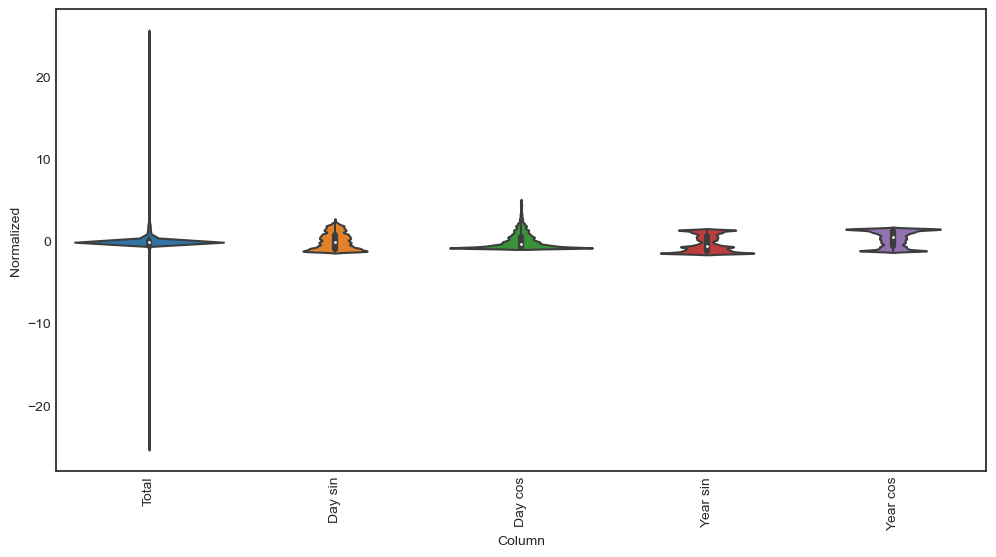

In [36]:
df_std = (df_final_features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_final_features.keys(), rotation=90)

Data windowing

- single prediction 24 hours into the future given a history of 24 hours results in total width of 48
- a prediction 1 hour into the future given a history of 6 hours results in total width of 7
- 1 label width equals 1 index, so total width of eg 7 means 7 labels

## Window creator

In [82]:
class WindowGen:

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    # shift represents the offset
    self.shift = shift

    self.total_window_size = input_width + shift

    # for slicing e.g. slice(0, 6) = start 0, stop 6, step 1
    self.input_slice = slice(0, input_width)
    # e.g. slicing an array with n steps, equal to -> np.arrange(10)[0:10:2] = {0, 2, 4, 6, 8} = slice(0, 10, 2)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])

      return inputs, labels


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

An example of a prediction of 1 hour into the future given a history of 6 hours with label width 1

In [91]:
w = WindowGen(input_width=6, label_width=1, shift=1,
                     label_columns=['Total'])
w

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Total']